## **RADI605: Modern Machine Learning**

### Assignment: Random Survival Forests
**Romen Samuel Rodis Wabina** <br>
Student, PhD Data Science in Healthcare and Clinical Informatics <br>
Clinical Epidemiology and Biostatistics, Faculty of Medicine (Ramathibodi Hospital) <br>
Mahidol University

Note: In case of Python Markdown errors, you may access the assignment through this GitHub [Link](https://github.com/rrwabina/RADI605/blob/main/05%20Adaptive%20Boosting/scripts/assignment.ipynb)

In [91]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import export as export 
import eli5
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from scipy.stats import reciprocal
from eli5.sklearn import PermutationImportance

from sksurv.ensemble import RandomSurvivalForest
from sksurv.tree import SurvivalTree
from sksurv.datasets import load_flchain, load_gbsg2, load_whas500
from sksurv.functions import StepFunction
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score)
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder, encode_categorical
from sksurv.util import Surv

import sksurv.datasets
from sksurv.datasets import load_whas500
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import ppscore as pps
import statistics
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index

#### Question 1: Please use a Worcester Heart Attack dataset <code>(whas500)</code>. Split whas500 into training and testing set (70:30).

In [60]:
X, y = load_whas500()
df_targets = pd.DataFrame(data = {'time': [y[i][1] for i in range(len(y))], 'event': [y[i][0] for i in range(len(y))]})
df_targets[:10].style.hide_index().highlight_min('event', color = 'yellow')

targets = ['fstat', 'lenfol']
data = pd.concat([X, pd.DataFrame(y.tolist(), columns = [targets[0], targets[1]])], axis = 1)
data['dead'] = np.where(data['fstat']==True, 1,0)
data = data.drop(columns=['fstat'])

print(f'Number of samples: {len(df_targets)}')
print(f'Number of right censored samples: {len(df_targets.query("event == False"))}')
print(f'Percentage of right censored samples: {100*len(df_targets.query("event == False"))/len(df_targets):.1f}%')


Number of samples: 500
Number of right censored samples: 285
Percentage of right censored samples: 57.0%


It is generally recommended to analyze the correlation among features to understand the prediction of the Random Survival Forests. Here, we utilize a heatmap that displays the correlation of two pairs of features from the given dataset. The correlation between <code>age</code> and <code>bmi</code> is -0.402484, which indicates a moderate negative correlation between the two variables. Similarly, the correlation between <code>diasbp</code> and <code>sysbp</code> is 0.610916, which indicates a strong positive correlation.

<AxesSubplot:>

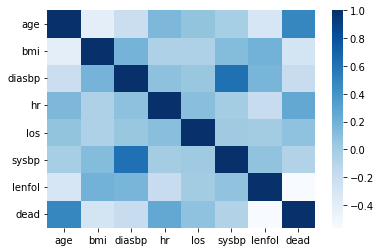

In [72]:
plt.figure(figsize = (6,4))
sns.heatmap(data.corr(),cmap = 'Blues', annot = False) 

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

print(f'Number of training samples: {len(y_train)}')
print(f'Number of test samples: {len(y_test)}')

Number of training samples: 350
Number of test samples: 150


#### Build a random survival forest model by using training set <code>(X_train, y_train)</code>.

In [71]:
def encoding(X, scale):
    if scale is True:
        cols = [type for type in X.columns if X[type].dtype.kind in ['i', 'f']]
    else:
        cols = [type for type in X.columns if X[type].dtype.kind not in ['i', 'f']]
    return cols

preprocessor = ColumnTransformer([('cat-preprocessor', OrdinalEncoder(), 
                                    encoding(X, scale = False)),
                                  ('standard-scaler',  StandardScaler(), 
                                    encoding(X, scale = True))],
                                  remainder = 'passthrough', sparse_threshold = 0)

param_grid =  {'n_estimators': [100, 300, 1000],
               'max_depth': [3, 5, 7],
               'min_samples_split': [2, 5, 7, 10],
               'min_samples_leaf':  [2, 5, 7, 15]}

cv = KFold(n_splits=3, shuffle=True, random_state=1)
survival_forest = GridSearchCV(RandomSurvivalForest(n_jobs = -1, random_state = 42), 
                           param_grid, 
                           cv = cv, 
                           scoring = concordance_index)
survival_forest.fit(X_train, y_train)
best_survival = survival_forest.best_estimator_

In [65]:
def plot_curve(survival_forest, X, var, survival_function = True):
    group1 = X[X[var] < statistics.median(X[var])]
    group2 = X[X[var] > statistics.median(X[var])]

    if survival_function is True:
        surv_group1 = survival_forest.predict_survival_function(group1.head(5), return_array = True)
        surv_group2 = survival_forest.predict_survival_function(group2.head(5), return_array = True)

    else:
        surv_group1 = survival_forest.predict_cumulative_hazard_function(group1.head(5), return_array = True)
        surv_group2 = survival_forest.predict_cumulative_hazard_function(group2.head(5), return_array = True)
    
    fig, (ax1, ax2) = plt.subplots(figsize = (13, 5), nrows = 1, ncols = 2)
    for s, i in zip(surv_group1, group1.head(5).index):
        ax1.step(survival_forest.event_times_, s, where = 'post', label = 'Patient ' + str(i))
    ax1.set_ylabel('Survival Probability')
    ax1.set_xlabel('Time in days')
    ax1.legend()
    ax1.grid(True)
    ax1.set_title(f'Top 5 patients based on median {var} (Age < {statistics.median(X[var])})', size = 10)

    for s, i in zip(surv_group2, group2.head(5).index):
        ax2.step(survival_forest.event_times_, s, where = 'post', label = 'Patient ' + str(i))
    ax2.set_ylabel('Survival Probability')
    ax2.set_xlabel('Time in days')
    ax2.legend()
    ax2.grid(True)
    ax2.set_title(f'Top 5 patients based on median {var} (Age > {statistics.median(X[var])})', size = 10)
    return surv_group1, surv_group2

#### Plot survival curve


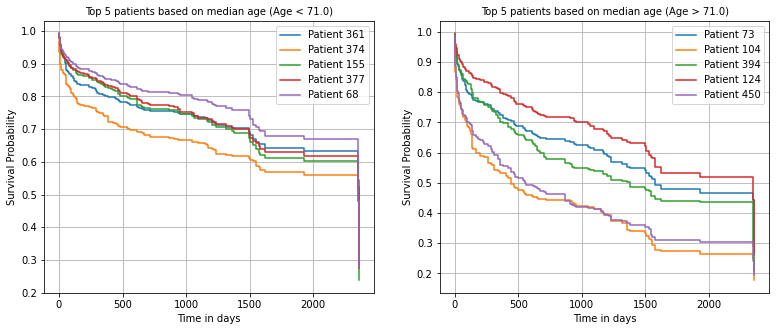

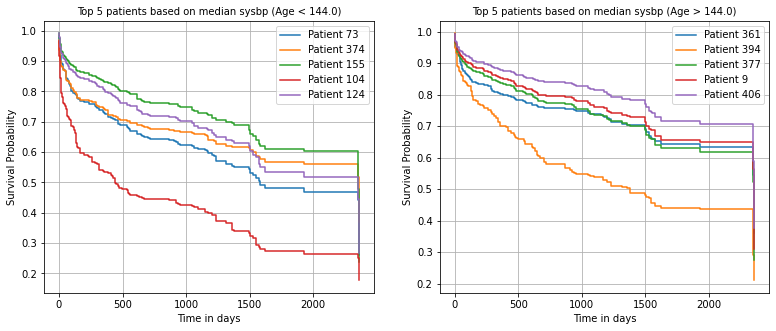

In [67]:
age_group1, age_group2 = plot_curve(best_survival, X_test, var = 'age')
age_group1, age_group2 = plot_curve(best_survival, X_test, var = 'sysbp')

#### Plot the predicted cumulative hazard function

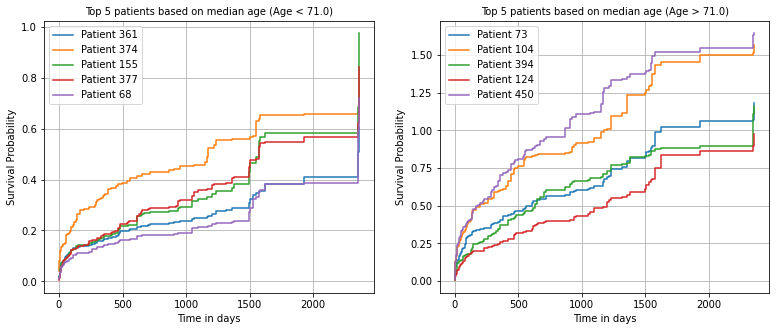

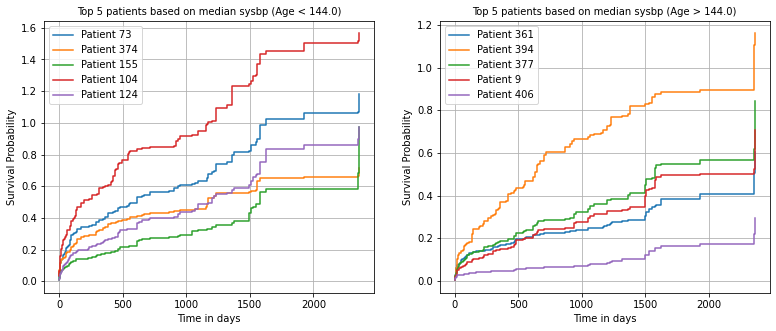

In [42]:
age_group1, age_group2 = plot_curve(best_survival, X_test, var = 'age',   survival_function = False)
age_group1, age_group2 = plot_curve(best_survival, X_test, var = 'sysbp', survival_function = False)

#### Evaluate your model performance by using testing set <code>(X_test, y_test)</code>.

Using the test data, we want to assess how well the model <code>best_survival</code> can distinguish survivors from deceased. The plot below shows that the model is performing well until the near-55th day. The performance between the first and second halves of the time range, however, clearly differs. Performance on the test data at near-55th day suddenly declines after enrollment, and then continues to decline until the 150th day. Note that the higher the AUC, the better the model is at predicting which individuals are more likely to experience death.

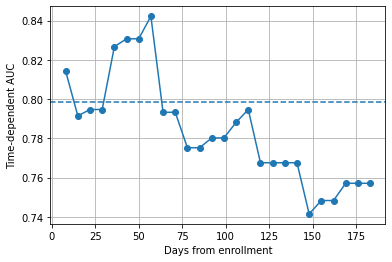

In [114]:
times = np.arange(8, 184, 7)
risk_score = best_survival.predict(X_test)
survival_auc, survival_mauc = cumulative_dynamic_auc(y_train, y_test,
                                                     risk_score, times)
plt.plot(times, survival_auc, marker = 'o')
plt.axhline(survival_mauc, linestyle = '--')
plt.xlabel('Days from enrollment')
plt.ylabel('Time-dependent AUC')
plt.grid(True)                                      

The most frequently used evaluation metric of survival models is the concordance index.

In [90]:
predictions = best_survival.predict(X_test)
c_index = concordance_index_censored(y_test[targets[0]], y_test[targets[1]], predictions)
print(f'The c-index of Random Survival Forest is given by {c_index[0]:.5f}')

The c-index of Random Survival Forest is given by 0.75030


A c-index of 0.75547 indicates that the Random Survival Forest model has a moderate ability to correctly rank pairs of patients in terms of their risk of death.

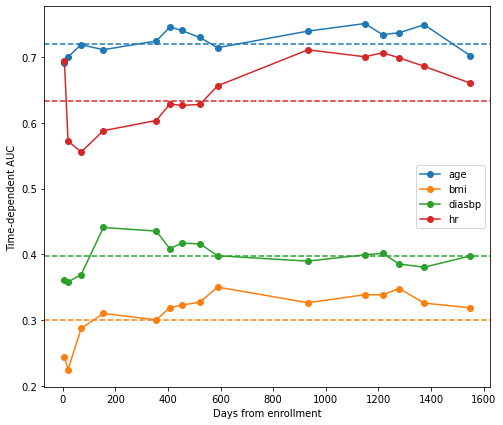

In [160]:
def get_correlated(df, threshold = 0.99):
    corr = df.corr()
    corr = corr[corr > threshold]
    corr = corr.dropna(axis = 1, how = 'all')
    corr = corr.dropna(axis = 0, how = 'all')
    vars_list = [col for col in corr.columns if any(corr[col].abs() > threshold)]

    for item in ['lenfol', 'dead']:
        vars_list.remove(item)
    return vars_list

def plot_cumulative_dynamic_auc(risk_score, label, color = None):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, times)
    plt.plot(times, auc, marker="o", color=color, label=label)
    plt.xlabel('Days from enrollment')
    plt.ylabel('Time-dependent AUC')
    plt.axhline(mean_auc, color=color, linestyle = '--')
    plt.legend()

times = np.percentile(y[targets[1]], np.linspace(5, 81, 15))
num_columns = get_correlated(data)[:-2]

imputer = SimpleImputer().fit(X_train.loc[:, num_columns])
X_test_imputed = imputer.transform(X_test.loc[:, num_columns])

plt.figure(figsize = (8, 7))
for i, col in enumerate(num_columns):
    plot_cumulative_dynamic_auc(X_test_imputed[:, i], col, color = 'C{}'.format(i))
    ret = concordance_index_ipcw(y_train, y_test, X_test_imputed[:, i], tau = times[-1])

The plot shows the estimated area under the time-dependent ROC at each time point and the average across all time points as dashed line.

Let's create a Kaplain-Meier. For the observed event, denote 1 if the patient has died while 0 if censored. 

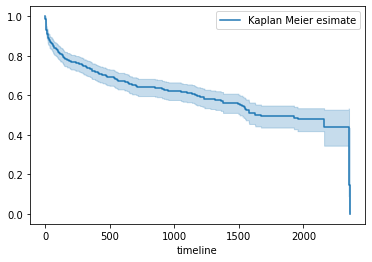

In [69]:
durations, event_observed = data['lenfol'], data['dead']

km = KaplanMeierFitter()
km.fit(durations, event_observed, label = 'Kaplan Meier esimate')
km.plot()
plt.show()

Age seems to have the strongest correlation with death, lets have a further look at this relationship. Investigate difference in survival time based on age

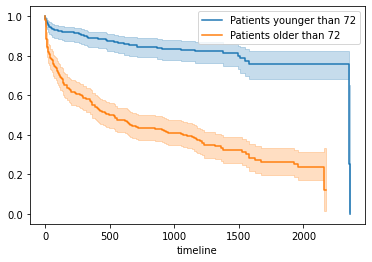

In [70]:
age_group_below_72 = data['age'] < statistics.median(data['age'])
age_group_above_72 = data['age'] > statistics.median(data['age'])

kmf = KaplanMeierFitter()
T, E = data['lenfol'], data['dead']

kmf.fit(T[age_group_below_72], E[age_group_below_72], label = 'Patients younger than 72')
ax = kmf.plot()
kmf.fit(T[age_group_above_72], E[age_group_above_72], label = 'Patients older than 72')
ax1 = kmf.plot(ax = ax)
plt.show()

####  Summarize the results